### Importing All necessary libraries

In [1]:
import os
import csv
import cv2
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential, Model, model_from_json
from keras.layers import Activation, Dense, Dropout, ELU, Flatten, Lambda, SpatialDropout2D
from keras.layers import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Define Data structures and functions

In [2]:
raw_samples =   []
car_images =    []
steering_angles=[]


#### defining image properties

In [3]:
# define the input size
height = 160
width = 320
depth = 3

# define how images should be cropped
reduction_upper = 70
reduction_lower = 25
reduction_left  = 0
reduction_right = 0

# specify the batch size and training epochs
batch_size = 32
epochs = 20

#### File-importing function

In [4]:
def import_samples(csv_filepath, samples):
    with open(csv_filepath) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)
      
        # samples = samples[1:] # headers removal  
        print("Total number of samples right now = ", len(samples))
   
    return samples

#### Augmentation Function

In [5]:
def augmentation(image_path, angle_single):
    
    image_single = cv2.imread(image_path)   
    image_flip = np.fliplr(image_single)    
    angle_negative = (-1.0)*angle_single

    return image_flip, angle_negative  
     

#### create the generator function

In [6]:
def generator(samples, batch_size):
    
    no_samples = len(samples)
    
    while 1:
        shuffle(samples)
        
        # loop through each batch of data
        for sample_pos in range(0, no_samples, batch_size):
            sample_batches = samples[sample_pos:sample_pos + batch_size]
            
            center_images = []
            center_angles = []
            left_images = []
            left_angles = []
            right_images=[]
            right_angles=[]
            correction = 0.25   # define the steering correction for left and right cameras.
            
            
            # loop through every single record within a batch of data
            for sample_no in sample_batches:     
                
                source_path_A = sample_no[0]   # specify the path for images taken by central camera.
                center_angle_single = float(sample_no[3])
                center_image_single_flip, angle_negative_center = augmentation(source_path_A,center_angle_single)
                center_image_single = cv2.imread(source_path_A)
                center_images.append(center_image_single)
                center_angles.append(center_angle_single)
                center_images.append(center_image_single_flip)
                center_angles.append(angle_negative_center)
#_____________________________________________________________________________________________________________________                
     
                source_path_B = sample_no[1]   # specify the path for images taken by left camera.        
                left_angle_single = float(sample_no[3])+correction
                left_image_single_flip, angle_negative_left = augmentation(source_path_B,left_angle_single)
                left_image_single = cv2.imread(source_path_B)                         
                center_images.append(left_image_single)
                center_angles.append(left_angle_single)
                center_images.append(left_image_single_flip)
                center_angles.append(angle_negative_left)
#_____________________________________________________________________________________________________________________                  
       
                source_path_C = sample_no[2]  # specify the path for images taken by right camera.
                right_angle_single = float(sample_no[3])-correction                
                right_image_single_flip, angle_negative_right = augmentation(source_path_C,right_angle_single)               
                right_image_single = cv2.imread(source_path_C)            
                center_images.append(right_image_single)
                center_angles.append(right_angle_single)
                center_images.append(right_image_single_flip)
                center_angles.append(angle_negative_right)
#_____________________________________________________________________________________________________________________  
       
            X_train = np.array(center_images)
            y_train = np.array(center_angles)
             
            yield shuffle(X_train, y_train)
                    
                                

In [7]:
# extracting data from CSV files
current_sample = import_samples('E:/DrivingDataTrackA/driving_log.csv', raw_samples)
current_sample = import_samples('E:/DrivingDataTrackA_enhanced/driving_log.csv', current_sample)
current_sample = import_samples('E:/DrivingDataTrackA_Recovery/driving_log.csv', current_sample)
current_sample = import_samples('E:/DrivingDataTrackB/driving_log.csv', current_sample)
current_sample = import_samples('E:/DrivingData/driving_log.csv', current_sample)

Total number of samples right now =  12314
Total number of samples right now =  17060
Total number of samples right now =  22615
Total number of samples right now =  38355
Total number of samples right now =  77049


In [8]:
# train-validation split
train_samples, valid_samples = train_test_split(current_sample, test_size=0.1)

In [9]:
# define two generators that will be fed into the Nvidia pipeline.
train_generator = generator(train_samples, batch_size)
valid_generator = generator(valid_samples, batch_size)

#### Use LeNet Architecture

In [10]:
model = Sequential()
model.add(Cropping2D(cropping=((reduction_upper,reduction_lower),
                               (reduction_left,reduction_right)),input_shape=(height, width, depth)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(16, (5, 5), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Convolution2D(32, (5, 5), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse',optimizer=Adam(lr = 0.0001),metrics=['mean_absolute_error'])
model.summary()


'''
# NVIDIA MODEL

model = Sequential()
model.add(Cropping2D(cropping=((reduction_upper,reduction_lower),
                               (reduction_left,reduction_right)),input_shape=(height, width, depth)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='tanh'))
model.compile(loss='mse', optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model.summary()

'''


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 316, 16)       1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 158, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 154, 32)       12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 77, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32032)             0         
__________

"\n# NVIDIA MODEL\n\nmodel = Sequential()\nmodel.add(Cropping2D(cropping=((reduction_upper,reduction_lower),\n                               (reduction_left,reduction_right)),input_shape=(height, width, depth)))\nmodel.add(Lambda(lambda x: (x / 255.0) - 0.5))\nmodel.add(Convolution2D(24, (5, 5), strides=(2, 2), activation='relu'))\nmodel.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='relu'))\nmodel.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='relu'))\nmodel.add(Convolution2D(64, (3, 3), activation='relu'))\nmodel.add(Convolution2D(64, (3, 3), activation='relu'))\nmodel.add(Dropout(0.25))\nmodel.add(Flatten())\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dropout(0.25))\nmodel.add(Dense(50, activation='relu'))\nmodel.add(Dropout(0.25))\nmodel.add(Dense(10, activation='relu'))\nmodel.add(Dropout(0.25))\nmodel.add(Dense(1, activation='tanh'))\nmodel.compile(loss='mse', optimizer=Adam(lr=0.0001),metrics=['accuracy'])\nmodel.summary()\n\n"

#### Creating a checkpoint

In [11]:
checkpointer = ModelCheckpoint(
                                    filepath= 'checkpoints/model{epoch:02d}.h5', 
                                    verbose=1, 
                                    save_best_only=False,
                                    save_weights_only=False,
                                    mode = 'auto'
                               
                              )

In [12]:
# starting the training process 
history_object = model.fit_generator(
                                            generator = train_generator, 
                                            steps_per_epoch=len(train_samples)/batch_size,
                                            epochs = epochs,
                                            verbose = 1,
                                            validation_data=valid_generator,
                                            validation_steps =len(valid_samples)/batch_size,
                                                                           
                                    )

print('Congratulations! Training completed successfully!')
model.save('model_LeNet_two.h5')
print('Model saved successfully!')

Epoch 1/20
2167/2167 [==============================] - 571s - loss: 0.0520 - mean_absolute_error: 0.1684 - val_loss: 0.0390 - val_mean_absolute_error: 0.1460
Epoch 2/20
2167/2167 [==============================] - 537s - loss: 0.0434 - mean_absolute_error: 0.1537 - val_loss: 0.0359 - val_mean_absolute_error: 0.1385
Epoch 3/20
2167/2167 [==============================] - 538s - loss: 0.0409 - mean_absolute_error: 0.1490 - val_loss: 0.0352 - val_mean_absolute_error: 0.1378
Epoch 4/20
2167/2167 [==============================] - 538s - loss: 0.0391 - mean_absolute_error: 0.1454 - val_loss: 0.0342 - val_mean_absolute_error: 0.1352
Epoch 5/20
2167/2167 [==============================] - 536s - loss: 0.0378 - mean_absolute_error: 0.1429 - val_loss: 0.0333 - val_mean_absolute_error: 0.1332
Epoch 6/20
2167/2167 [==============================] - 538s - loss: 0.0365 - mean_absolute_error: 0.1402 - val_loss: 0.0330 - val_mean_absolute_error: 0.1329
Epoch 7/20
2167/2167 [========================

dict_keys(['val_mean_absolute_error', 'val_loss', 'mean_absolute_error', 'loss'])


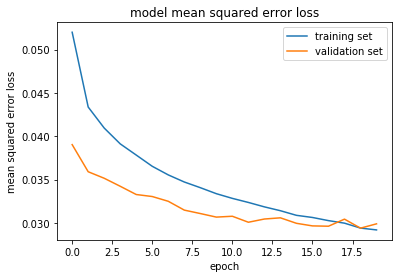

In [13]:

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
